<a href="https://colab.research.google.com/github/vvvleva/kurs2_mmvbd/blob/main/Kyrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer # Выполнение энкодинга
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as f

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a1261955351499e720f1d216555d1bfa601a6e0cf8faa4256180eec3ba027601
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
spark = SparkSession.builder.appName("PySparkBankChurners").getOrCreate()
#Создаём Spark сессию
spark

In [4]:
spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("Spark ML Production")\
    .getOrCreate()

## Загрузка и знакомство с данными

In [5]:
raw = spark\
    .read\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .csv("/content/BankChurners.csv")

Убираем первую и последние две колонки

In [6]:
columns = raw.columns
columnsLen = len(columns)
colsToDrop = columns[0].split() + columns[columnsLen-2:columnsLen]

df = raw.drop(*colsToDrop)

df.show(5, False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+--------

### Определяем типы колонок


In [7]:
df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)



Обработка результата с помощью метода dtypes.
Вывод в удобном виде названия колонок и их типа:

In [8]:
dt = df.dtypes
for r in dt:
    print(f"{r[0]:>25}\t{r[1]}")

           Attrition_Flag	string
             Customer_Age	int
                   Gender	string
          Dependent_count	int
          Education_Level	string
           Marital_Status	string
          Income_Category	string
            Card_Category	string
           Months_on_book	int
 Total_Relationship_Count	int
   Months_Inactive_12_mon	int
    Contacts_Count_12_mon	int
             Credit_Limit	double
      Total_Revolving_Bal	int
          Avg_Open_To_Buy	double
     Total_Amt_Chng_Q4_Q1	double
          Total_Trans_Amt	int
           Total_Trans_Ct	int
      Total_Ct_Chng_Q4_Q1	double
    Avg_Utilization_Ratio	double


Посмотрим соклько колонок каждого типа

In [9]:
from itertools import groupby

dt.sort(key=lambda x: x[1])

for k, g in groupby(dt, lambda x: x[1]):
    print(k, len(list(g)))

double 5
int 9
string 6


### Проверим числовые колонки

In [10]:
numericColumns = list(
    map(lambda x: x[0],
        filter(lambda x: x[1] == "double" or x[1] == "int",
               df.dtypes)))
df.select(*numericColumns).summary().show()

+-------+-----------------+------------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|summary|     Customer_Age|   Dependent_count|    Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|     Credit_Limit|Total_Revolving_Bal|  Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|  Total_Trans_Amt|   Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-------+-----------------+------------------+------------------+------------------------+----------------------+---------------------+-----------------+-------------------+-----------------+--------------------+-----------------+-----------------+-------------------+---------------------+
|  count|            10127|             10127|             10127|                   10127|                 10127|              

In [11]:
df.groupBy("Customer_Age").count().show(30) # Значение колонки Customer_Age

+------------+-----+
|Customer_Age|count|
+------------+-----+
|          31|   91|
|          65|  101|
|          53|  387|
|          34|  146|
|          28|   29|
|          26|   78|
|          27|   32|
|          44|  500|
|          47|  479|
|          52|  376|
|          40|  361|
|          57|  223|
|          54|  307|
|          48|  472|
|          64|   43|
|          41|  379|
|          43|  473|
|          37|  260|
|          61|   93|
|          35|  184|
|          59|  157|
|          55|  279|
|          39|  333|
|          49|  495|
|          51|  398|
|          63|   65|
|          50|  452|
|          45|  486|
|          38|  303|
|          73|    1|
+------------+-----+
only showing top 30 rows



### Построим график для получения распределения клиентов по возрасту

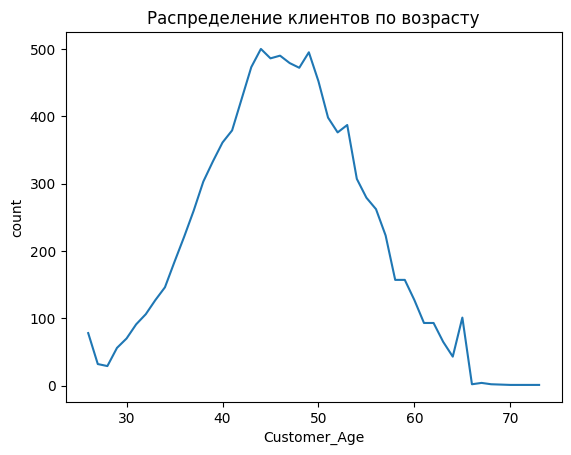

In [12]:
import matplotlib.pyplot as plt

age = df.groupBy("Customer_Age").count().orderBy("Customer_Age")
x_val = [val["Customer_Age"] for val in age.select("Customer_Age").collect()]
y_val = [val["count"] for val in age.select("count").collect()]

plt.plot(x_val, y_val)

plt.xlabel("Customer_Age")
plt.ylabel("count")
plt.title("Распределение клиентов по возрасту")

plt.show()

## Целевая колонка

In [13]:
dft = df\
    .withColumn("target",
                f.when(df["Attrition_Flag"] == "Existing Customer",
                       0).otherwise(1))

dft.select("Attrition_Flag", "target").show(5, False)

+-----------------+------+
|Attrition_Flag   |target|
+-----------------+------+
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
+-----------------+------+
only showing top 5 rows



### Проверка сбалансированности данных

In [14]:
dft.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1627|
|     0| 8500|
+------+-----+



### Oversampling

In [15]:
# Делим DataFrame на 2
df1 = dft.filter(dft["target"] == 1)
df0 = dft.filter(dft["target"] == 0)

# Вычисление кол-ва строк в каждом фрейме данных и сохранение значений в переменные
df1count = df1.count()
df0count = df0.count()

int(df0count / df1count) # Целочисленное деление между числами df 0 и df 1

5

In [16]:
df1Over = df1\
    .withColumn("dummy",
                f.explode(
                    f.array(*[f.lit(x)
                              for x in range(int(df0count / df1count))])))\
    .drop("dummy")

df1Over.show(10, False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+---------

In [17]:
data = df0.unionAll(df1Over)
data.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     0| 8500|
|     1| 8135|
+------+-----+



# Подготовка данных. Работа с признаками
## Проверка корреляции числовых признаков
### Используем DataFrameStatFunctions

In [18]:
from itertools import combinations

numericColumnsPairs = list(combinations(numericColumns, 2))
numericColumnsPairs

[('Customer_Age', 'Dependent_count'),
 ('Customer_Age', 'Months_on_book'),
 ('Customer_Age', 'Total_Relationship_Count'),
 ('Customer_Age', 'Months_Inactive_12_mon'),
 ('Customer_Age', 'Contacts_Count_12_mon'),
 ('Customer_Age', 'Credit_Limit'),
 ('Customer_Age', 'Total_Revolving_Bal'),
 ('Customer_Age', 'Avg_Open_To_Buy'),
 ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
 ('Customer_Age', 'Total_Trans_Amt'),
 ('Customer_Age', 'Total_Trans_Ct'),
 ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
 ('Customer_Age', 'Avg_Utilization_Ratio'),
 ('Dependent_count', 'Months_on_book'),
 ('Dependent_count', 'Total_Relationship_Count'),
 ('Dependent_count', 'Months_Inactive_12_mon'),
 ('Dependent_count', 'Contacts_Count_12_mon'),
 ('Dependent_count', 'Credit_Limit'),
 ('Dependent_count', 'Total_Revolving_Bal'),
 ('Dependent_count', 'Avg_Open_To_Buy'),
 ('Dependent_count', 'Total_Amt_Chng_Q4_Q1'),
 ('Dependent_count', 'Total_Trans_Amt'),
 ('Dependent_count', 'Total_Trans_Ct'),
 ('Dependent_count', 'Total_Ct_Chn

In [19]:
corr = list(
    filter(
        lambda x: abs(x[2]) > 0.6,
        map(lambda x: (x[0], x[1], data.stat.corr(x[0], x[1])), numericColumnsPairs)))

In [20]:
corr.sort(key=lambda x: x[2])
for i in reversed(corr):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

             Credit_Limit           Avg_Open_To_Buy	0.9952040726156252
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243807
             Customer_Age            Months_on_book	0.7805047706891143
      Total_Revolving_Bal     Avg_Utilization_Ratio	0.6946855441968229


### Оставим числовые колонки только с низкой корреляцией

In [21]:
numericColumnsFinal = list(
    set(numericColumns) - set(map(lambda x: x[1], corr)))

numericColumnsFinal

['Contacts_Count_12_mon',
 'Dependent_count',
 'Months_Inactive_12_mon',
 'Total_Amt_Chng_Q4_Q1',
 'Customer_Age',
 'Total_Ct_Chng_Q4_Q1',
 'Credit_Limit',
 'Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Total_Trans_Amt']

### Категориальные признаки
Индексируем строковые колонки

In [22]:
from pyspark.ml.feature import StringIndexer

stringColumns = list(
    filter(
        lambda x: x != "Attrition_Flag",
        map(lambda x: x[0],
            filter(lambda x: x[1] == "string", data.dtypes))))

stringColumnsIndexed = list(map(lambda x: x + "_Indexed", stringColumns))

# Создаем объект StringIndexer для преобразования строковых значений в числовые индексы
indexer = StringIndexer()\
    .setInputCols(stringColumns)\
    .setOutputCols(stringColumnsIndexed)

indexed = indexer.fit(data).transform(data)
indexed.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Status_Indexed|Income_Category_Indexed|Card_Category_Indexed|
+-----------------+------------+------+---------------+---------------+---------

### Кодируем категориальные признаки

In [23]:
from pyspark.ml.feature import OneHotEncoder

catColumns = list(map(lambda x: x + "_Coded", stringColumnsIndexed))

encoder = OneHotEncoder()\
    .setInputCols(stringColumnsIndexed)\
    .setOutputCols(catColumns)

encoded = encoder.fit(indexed).transform(indexed)
encoded.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Stat

## Сборка признаков в вектор

In [24]:
from pyspark.ml.feature import VectorAssembler

featureColumns = numericColumnsFinal + catColumns # Общий список значений

# Создаем объект VectorAssembler для объединения выбранных столбцов в один столбец "features"
assembler = VectorAssembler()\
    .setInputCols(featureColumns)\
    .setOutputCol("features") # Применяем VectorAssembler к закодированным данным, создаем новый столбец "features", содержащий объединенные значения

assembled = assembler.transform(encoded)
assembled.show(5, truncate=False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+---------------------------------------------------------------------------------------------------------------------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_A

In [25]:
assembled.select("features").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------+
|(28,[0,1,2,3,4,5,6,7,8,9,12,17,23,25],[3.0,3.0,1.0,1.335,45.0,1.625,12691.0,5.0,777.0,1144.0,1.0,1.0,1.0,1.0])       |
|(28,[0,1,2,3,4,5,6,7,8,9,10,11,18,20,25],[2.0,5.0,1.0,1.541,49.0,3.714,8256.0,6.0,864.0,1291.0,1.0,1.0,1.0,1.0,1.0]) |
|(28,[1,2,3,4,5,6,7,9,11,17,22,25],[3.0,1.0,2.594,51.0,2.333,3418.0,4.0,1887.0,1.0,1.0,1.0,1.0])                      |
|(28,[0,1,2,3,4,5,6,7,8,9,10,12,19,20,25],[1.0,4.0,4.0,1.405,40.0,2.333,3313.0,3.0,2517.0,1171.0,1.0,1.0,1.0,1.0,1.0])|
|(28,[1,2,3,4,5,6,7,9,14,17,23,25],[3.0,1.0,2.175,40.0,2.5,4716.0,5.0,816.0,1.0,1.0,1.0,1.0])                         |
+---------------------------------------

### Нормализация

In [26]:
from pyspark.ml.feature import MinMaxScaler

# Создается объект, для которого данные берутся из features, а результат записывается в scaledFeatures
scaler = MinMaxScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures")

# Применяем scaler к собранному датафрейму assembled и сохраняем результат в переменную scaled
scaled = scaler.fit(assembled).transform(assembled)

# Вывод первых 5 строк с колонками "features" и "scaledFeatures" из датафрейма scaled, без усечения информации (False)
scaled.select("features", "scaledFeatures").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |scaledFeatures                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Отбор признаков

In [27]:
from pyspark.ml.feature import UnivariateFeatureSelector

selector = UnivariateFeatureSelector()\
    .setFeatureType("continuous")\
    .setLabelType("categorical")\
    .setSelectionMode("percentile")\
    .setSelectionThreshold(0.75)\
    .setFeaturesCol("scaledFeatures")\
    .setLabelCol("target")\
    .setOutputCol("selectedFeatures")

dataF = selector.fit(scaled).transform(scaled)

dataF.select("scaledFeatures", "selectedFeatures").show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                |selectedFeatures                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------

# Моделирование
### Обучающая и тестовая выборки

In [28]:
tt = dataF.randomSplit([0.7, 0.3])
training = tt[0]
test = tt[1]

print(f"training\t{training.count():>5}\ntest    \t{test.count():>5}")

training	11736
test    	 4899


### Логистическая регрессия

In [29]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()\
    .setMaxIter(1000)\
    .setRegParam(0.2)\
    .setElasticNetParam(0.8)\
    .setFamily("binomial")\
    .setFeaturesCol("selectedFeatures")\
    .setLabelCol("target")

lrModel = lr.fit(training)

print(f"Coefficients: {lrModel.coefficients}\nIntercept: {lrModel.intercept}")

Coefficients: (21,[5],[-1.8778863533094643])
Intercept: 0.3019093944678515


### Краткое содержание тренинга

In [30]:
trainingSummary = lrModel.summary

print(f"accuracy: {trainingSummary.accuracy}")
print(f"areaUnderROC: {trainingSummary.areaUnderROC}")

accuracy: 0.706799591002045
areaUnderROC: 0.7477972379239237


# Оценка
### Проверка модели на тестовой выборке

In [31]:
predicted = lrModel.transform(test)

predicted.select("target", "prediction").show(10, False)

+------+----------+
|target|prediction|
+------+----------+
|0     |0.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
+------+----------+
only showing top 10 rows



In [32]:
predicted.select("target", "rawPrediction", "probability", "prediction").show(10, False)

+------+--------------------------------------------+----------------------------------------+----------+
|target|rawPrediction                               |probability                             |prediction|
+------+--------------------------------------------+----------------------------------------+----------+
|0     |[0.2037142870909704,-0.2037142870909704]    |[0.5507531737290544,0.4492468262709456] |0.0       |
|0     |[-0.14415480582149906,0.14415480582149906]  |[0.46402357797149585,0.5359764220285042]|1.0       |
|0     |[0.06567902202541198,-0.06567902202541198]  |[0.5164138555133966,0.4835861444866034] |0.0       |
|0     |[-0.008142035482175958,0.008142035482175958]|[0.49796450237433676,0.5020354976256632]|1.0       |
|0     |[-0.059210027319617,0.059210027319617]      |[0.4852018162405977,0.5147981837594022] |1.0       |
|0     |[-0.07336749040326399,0.07336749040326399]  |[0.4816663505081883,0.5183336494918117] |1.0       |
|0     |[-0.13353670850876379,0.13353670850876

### Оценка применения модели к тестовой выборке

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("target")

print(f"areaUnderROC: {evaluator.evaluate(predicted)}")

areaUnderROC: 0.7391847599747119


### Матрица ошибок

In [34]:
tp = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 1)).count()
tn = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 0)).count()
fp = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 1)).count()
fn = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 0)).count()

print(f"Confusion Matrix:\n{tp:>4}\t{fp:>4}\n{fn:>4}\t{tn:>4}")

Confusion Matrix:
1420	 544
 922	2013


### Accuracy, Precision, Recall

In [35]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

Accuracy = 0.7007552561747296
Precision = 0.7230142566191446
Recall = 0.6063193851409052


## Настройка модели. Подбор гиперпараметров

In [36]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])\
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

trainValidationSplit = TrainValidationSplit()\
    .setEstimator(lr)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setTrainRatio(0.7)\

model = trainValidationSplit.fit(dataF)

In [37]:
# Извлечение параметров лучшей модели из обученной
param_map = model.bestModel.extractParamMap()
for i in param_map:
    print(f"{i.name:<16}\t{param_map[i]}")

aggregationDepth	2
elasticNetParam 	0.0
family          	binomial
featuresCol     	selectedFeatures
fitIntercept    	True
labelCol        	target
maxBlockSizeInMB	0.0
maxIter         	1000
predictionCol   	prediction
probabilityCol  	probability
rawPredictionCol	rawPrediction
regParam        	0.01
standardization 	True
threshold       	0.5
tol             	1e-06


In [38]:
bestML = model.bestModel

# Сборка Pipeline

In [39]:
from pyspark.ml import Pipeline

# Создание конвейера обработки данных с последовательностью этапов:
pipeline = Pipeline().setStages(
    [indexer, encoder, assembler, scaler, selector, bestML])

# Разделение на обучающую и тестовую выборки
[trainingData, testData] = data.randomSplit([0.7, 0.3])

# Обучение конвейера на обучающих данных с помощью метода fit() сохранение обученной модели в pipelineModel
pipelineModel = pipeline.fit(trainingData)

## Сохранение модели

In [40]:
pipelineModel.write().overwrite().save("/content/pipelineModel")